This notebook is used to determine the characteristic proper motions of both the Large Magellanic Cloud and the Small Magellanic cloud using Gaia DR2 data.

This first part is importing the standard libraries and the data

In [15]:
###Import the usual libraries

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

from scipy.stats import kurtosis, skew, iqr

In [2]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [3]:
###determine coordinates for periphery points in LMC and SMC

print(SkyCoord(l = 290*u.degree, b = -35*u.degree, frame = 'galactic').icrs) #LMC
print(SkyCoord(l = 299*u.degree, b = -42*u.degree, frame = 'galactic').icrs) #SMC

<SkyCoord (ICRS): (ra, dec) in deg
    (64.24290029, -76.4305723)>
<SkyCoord (ICRS): (ra, dec) in deg
    (24.05542837, -74.78460052)>


In [6]:
###Import the Gaia data for 1 degree diamater region around the above points

filepath1 = '/Users/joshpovick/Desktop/Research/fits/gaialmcper_1degdia.fits' #ra: 64.24290029 dec:-76.4305723
filepath2 = '/Users/joshpovick/Desktop/Research/fits/gaiasmcper_1degdia.fits' #ra: 24.05542837 dec:-74.78460052

lmcper = fits.getdata(filepath1,1)
smcper = fits.getdata(filepath2,1)

This part is examining the raw data

In [8]:
###Gaussian function definition

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

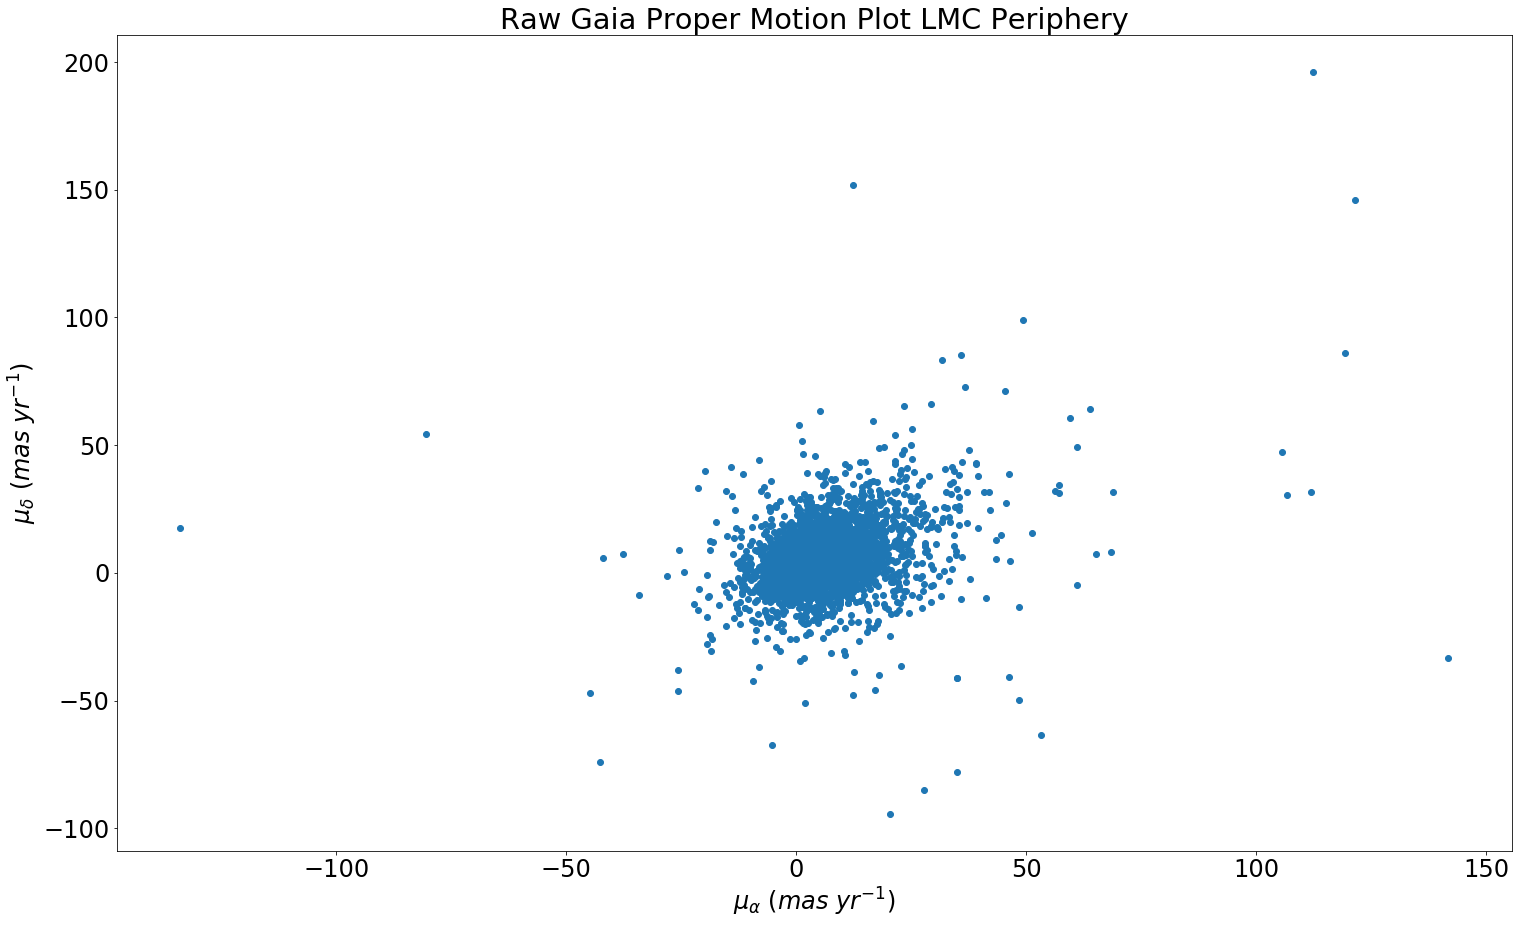

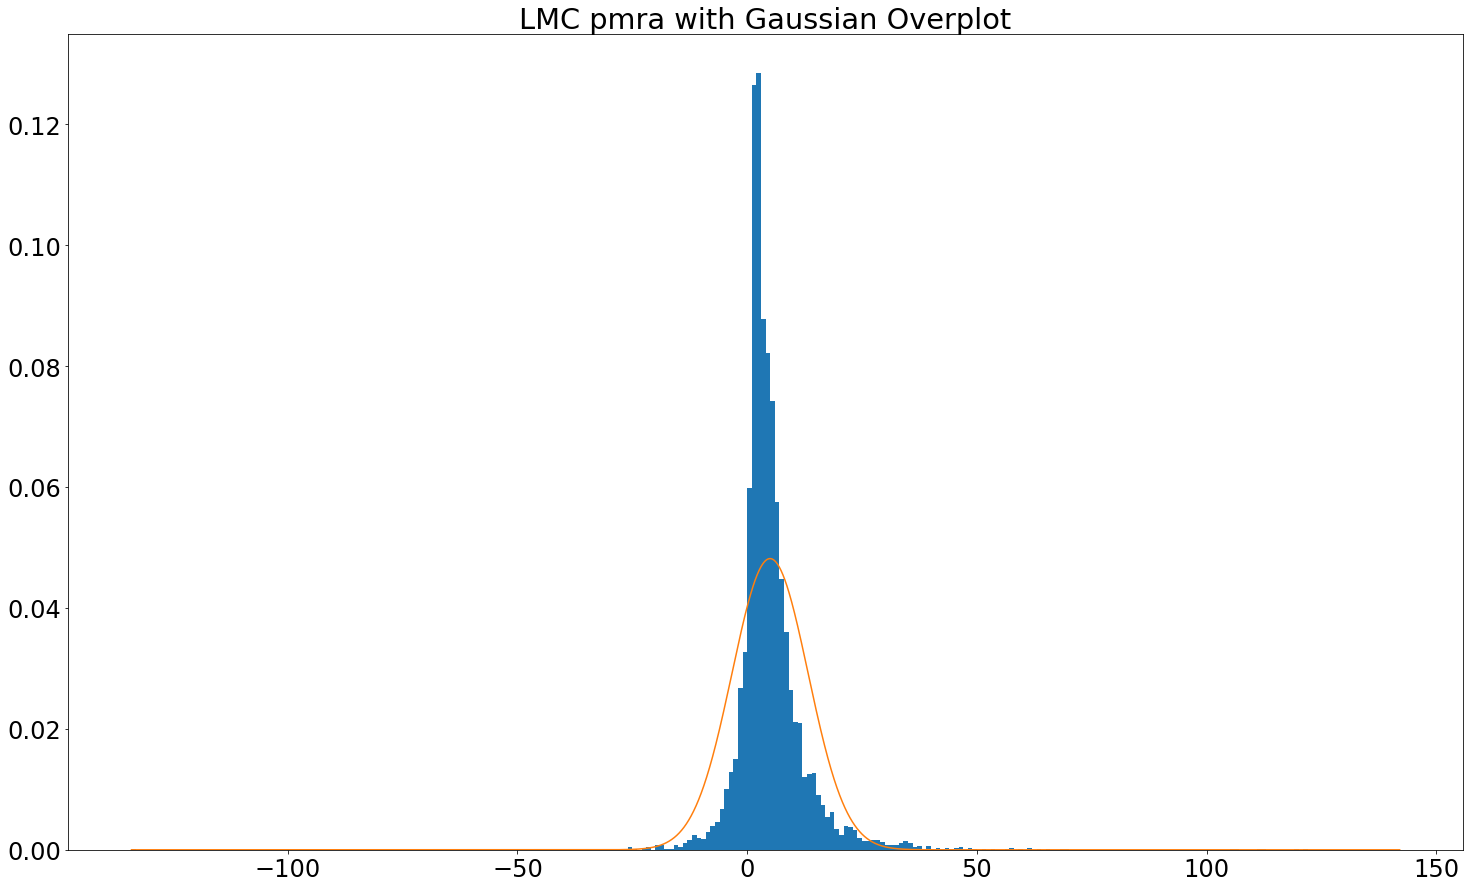

mean = 4.972736092184623
std = 8.281319872050481
skew = 2.902538903613102
kurtosis = 54.96801417759312
median = 3.5866005173141033
IQR = 5.4819872151945015


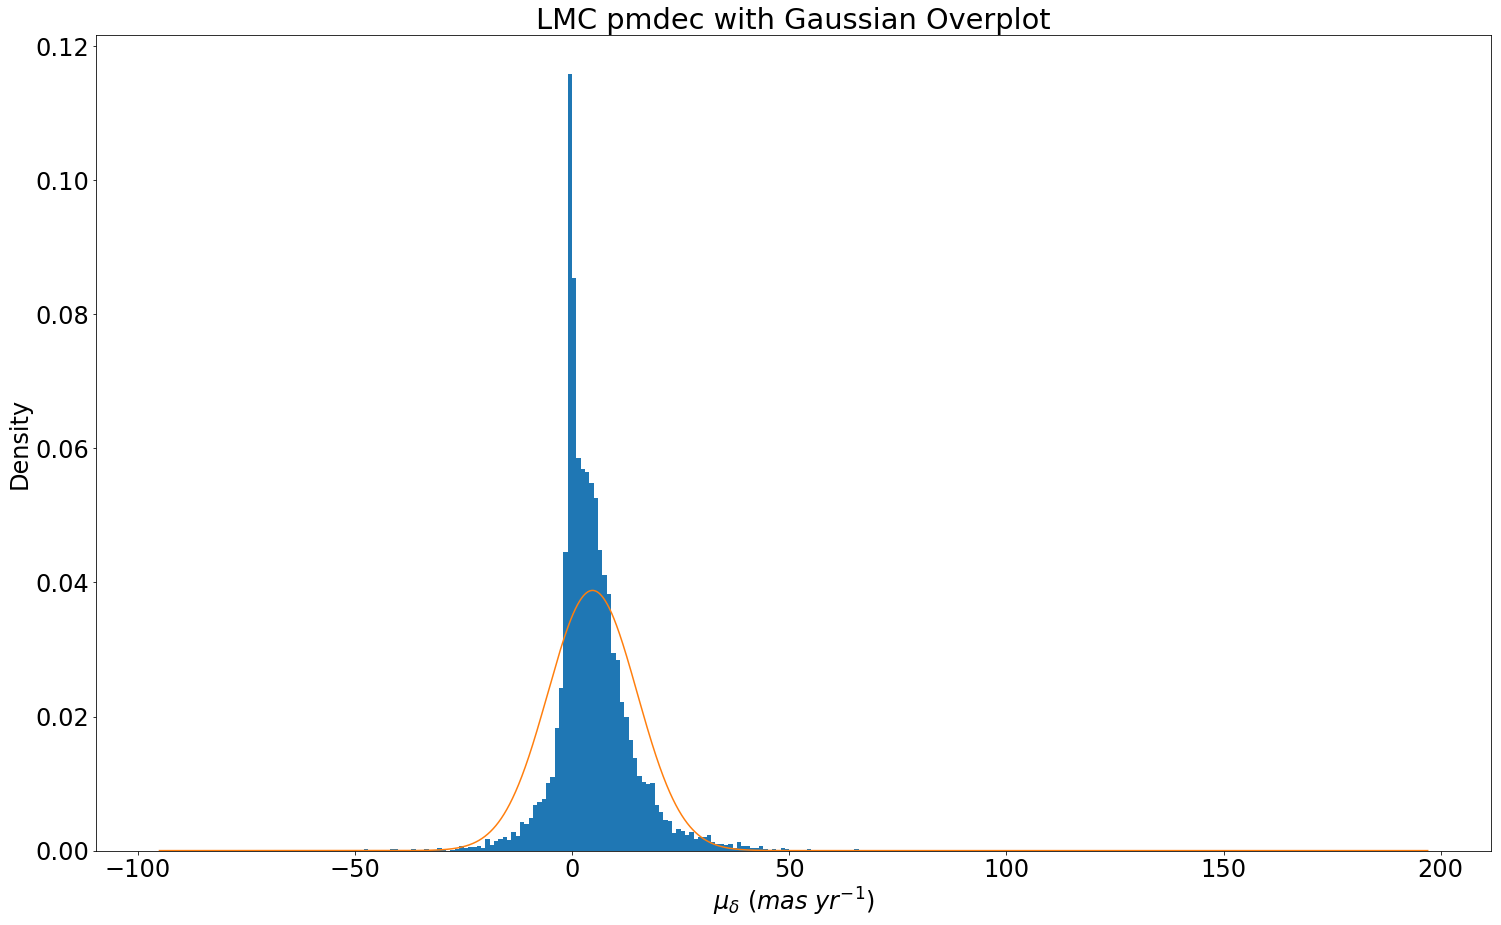

mean = 4.7076353815227305
std = 10.279501376469607
skew = 2.19653576361184
kurt = 38.36078929870392
median = 3.3299314931797124
IQR = 8.66109181397256


In [11]:
###Raw proper motion plot and accompanying histograms for the LMC with statistics printout
lpmra = lmcper['pmra']
lpmdec = lmcper['pmdec']

#Scatter plot of SMC proper motions
plt.figure(figsize=[25,15])
plt.scatter(lpmra,lpmdec)
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot LMC Periphery')
plt.savefig('rawlmcpm.pdf',bbox_inches='tight')
plt.show()

#pmra histogram with gaussian overplot
cleanlpmra = [x for x in lpmra if str(x) != 'nan']
avglpmra = np.mean(cleanlpmra)
siglpmra = np.std(cleanlpmra)
zlra = np.linspace(-134,142,10000)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmra,range(-134,142),density=True)
plt.plot(zlra,gaussian(zlra,avglpmra,siglpmra))
plt.title('LMC pmra with Gaussian Overplot')
plt.savefig('rawlmcpmra.pdf',bbox_inches='tight')
plt.show()

#pmra statistics
print('mean = '+ str(np.mean(cleanlpmra)))
print('std = '+ str(np.std(cleanlpmra)))
print('skew = '+ str(skew(cleanlpmra)))
print('kurtosis = '+ str(kurtosis(cleanlpmra)))
print('median = '+ str(np.median(cleanlpmra)))
print('IQR = '+ str(iqr(cleanlpmra)))

#pmdec histogram with gaussian overplot
cleanlpmdec = [x for x in lpmdec if str(x) != 'nan']
avglpmdec = np.mean(cleanlpmdec)
siglpmdec = np.std(cleanlpmdec)
zldec = np.linspace(-95,197,10000)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmdec,range(-95,197),density=True)
plt.plot(zldec,gaussian(zldec,avglpmdec,siglpmdec))
plt.title('LMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawlmcpmdec.pdf',bbox_inches='tight')
plt.show()

#pmdec statistics
print('mean = '+ str(np.mean(cleanlpmdec)))
print('std = '+ str(np.std(cleanlpmdec)))
print('skew = '+ str(skew(cleanlpmdec)))
print('kurt = '+ str(kurtosis(cleanlpmdec)))
print('median = '+ str(np.median(cleanlpmdec)))
print('IQR = '+ str(iqr(cleanlpmdec)))

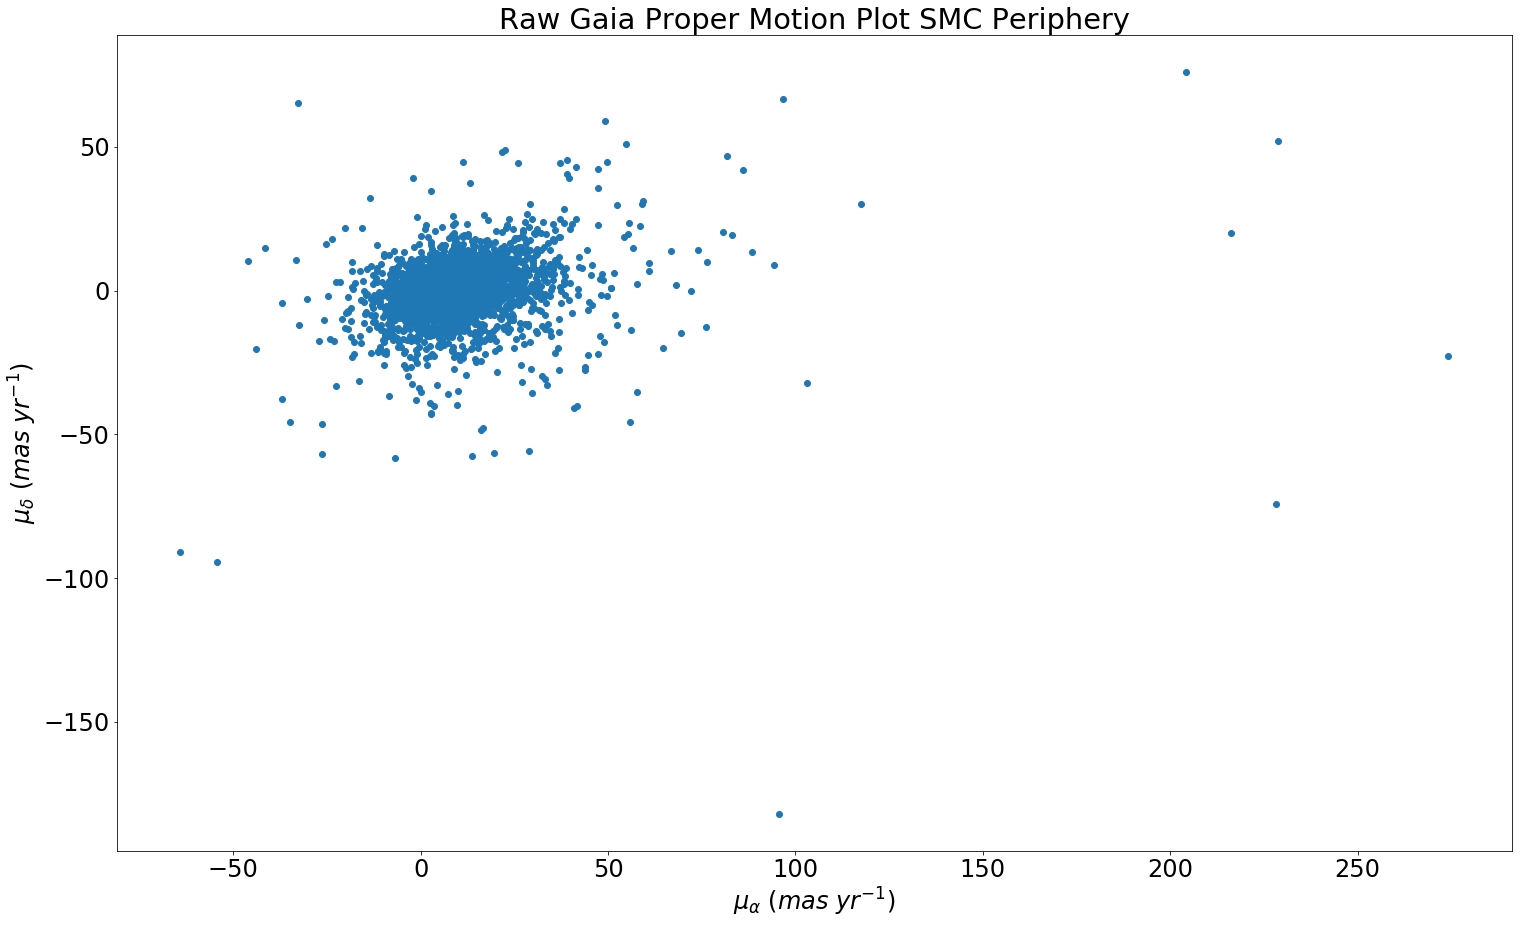

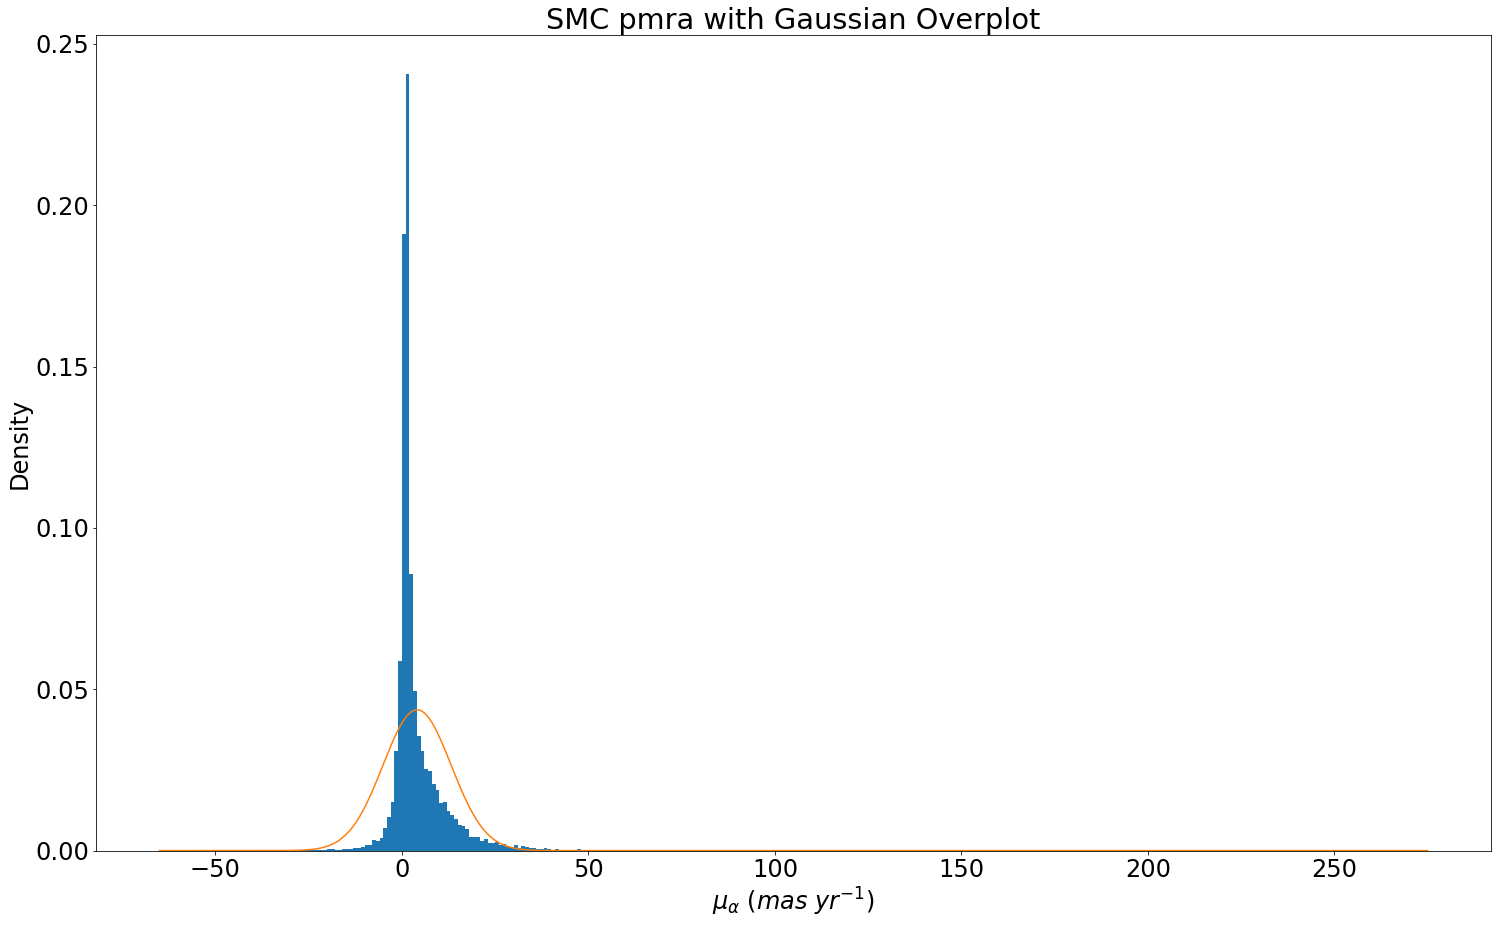

mean = 4.060394066222031
std = 9.144958887347167
skew = 8.396415923998145
kurt = 175.39368194016348
median = 1.5481506166339962
IQR = 4.404308815633078


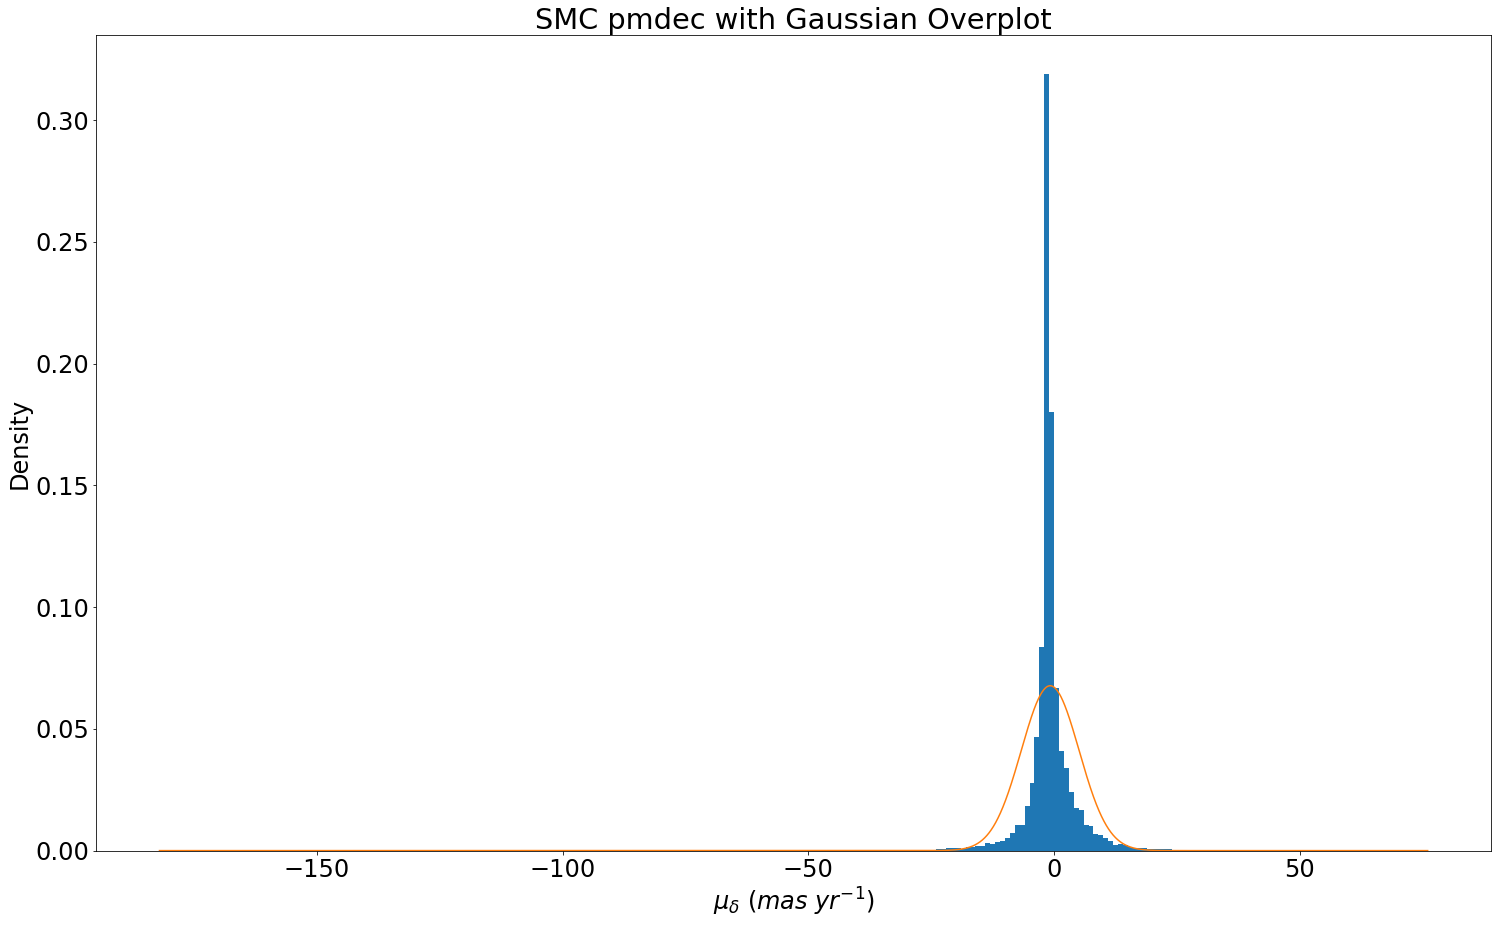

mean = -0.7977984950028141
std = 5.89254053748466
skew = -2.756973261025786
kurt = 103.86610561995501
median = -1.1504470092479984
IQR = 2.0730054140371257


In [16]:
###Raw proper motion plot and accompanying histograms for the SMC with statistics printout
spmra = smcper['pmra']
spmdec = smcper['pmdec']

#Scatter plot of LMC proper motions
plt.figure(figsize=[25,15])
plt.scatter(spmra,spmdec)
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot SMC Periphery')
plt.savefig('rawsmcpm.pdf',bbox_inches='tight')
plt.show()

#pmra histogram with gaussian overplot
cleanspmra = [x for x in spmra if str(x) != 'nan']
avgspmra = np.mean(cleanspmra)
sigspmra = np.std(cleanspmra)
zsra = np.linspace(-65,275,10000)

plt.figure(figsize=[25,15])
plt.hist(cleanspmra,range(-65,275), density=True)
plt.plot(zsra,gaussian(zsra,avgspmra,sigspmra))
plt.title('SMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmra.pdf',bbox_inches='tight')
plt.show()

#pmra statistics
print('mean = '+ str(np.mean(cleanspmra)))
print('std = '+ str(np.std(cleanspmra)))
print('skew = '+ str(skew(cleanspmra)))
print('kurt = '+ str(kurtosis(cleanspmra)))
print('median = '+ str(np.median(cleanspmra)))
print('IQR = '+ str(iqr(cleanspmra)))

#pmdec histogram with gaussian overplot
cleanspmdec = [x for x in spmdec if str(x) != 'nan']
avgspmdec = np.mean(cleanspmdec)
sigspmdec = np.std(cleanspmdec)
zsdec = np.linspace(-182,76,10000)

plt.figure(figsize=[25,15])
plt.hist(cleanspmdec,range(-182,76), density=True)
plt.plot(zsdec,gaussian(zsdec,avgspmdec,sigspmdec))
plt.title('SMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmdec.pdf',bbox_inches='tight')
plt.show()

#pmdec statistics
print('mean = '+ str(np.mean(cleanspmdec)))
print('std = '+ str(np.std(cleanspmdec)))
print('skew = '+ str(skew(cleanspmdec)))
print('kurt = '+ str(kurtosis(cleanspmdec)))
print('median = '+ str(np.median(cleanspmdec)))
print('IQR = '+ str(iqr(cleanspmdec)))

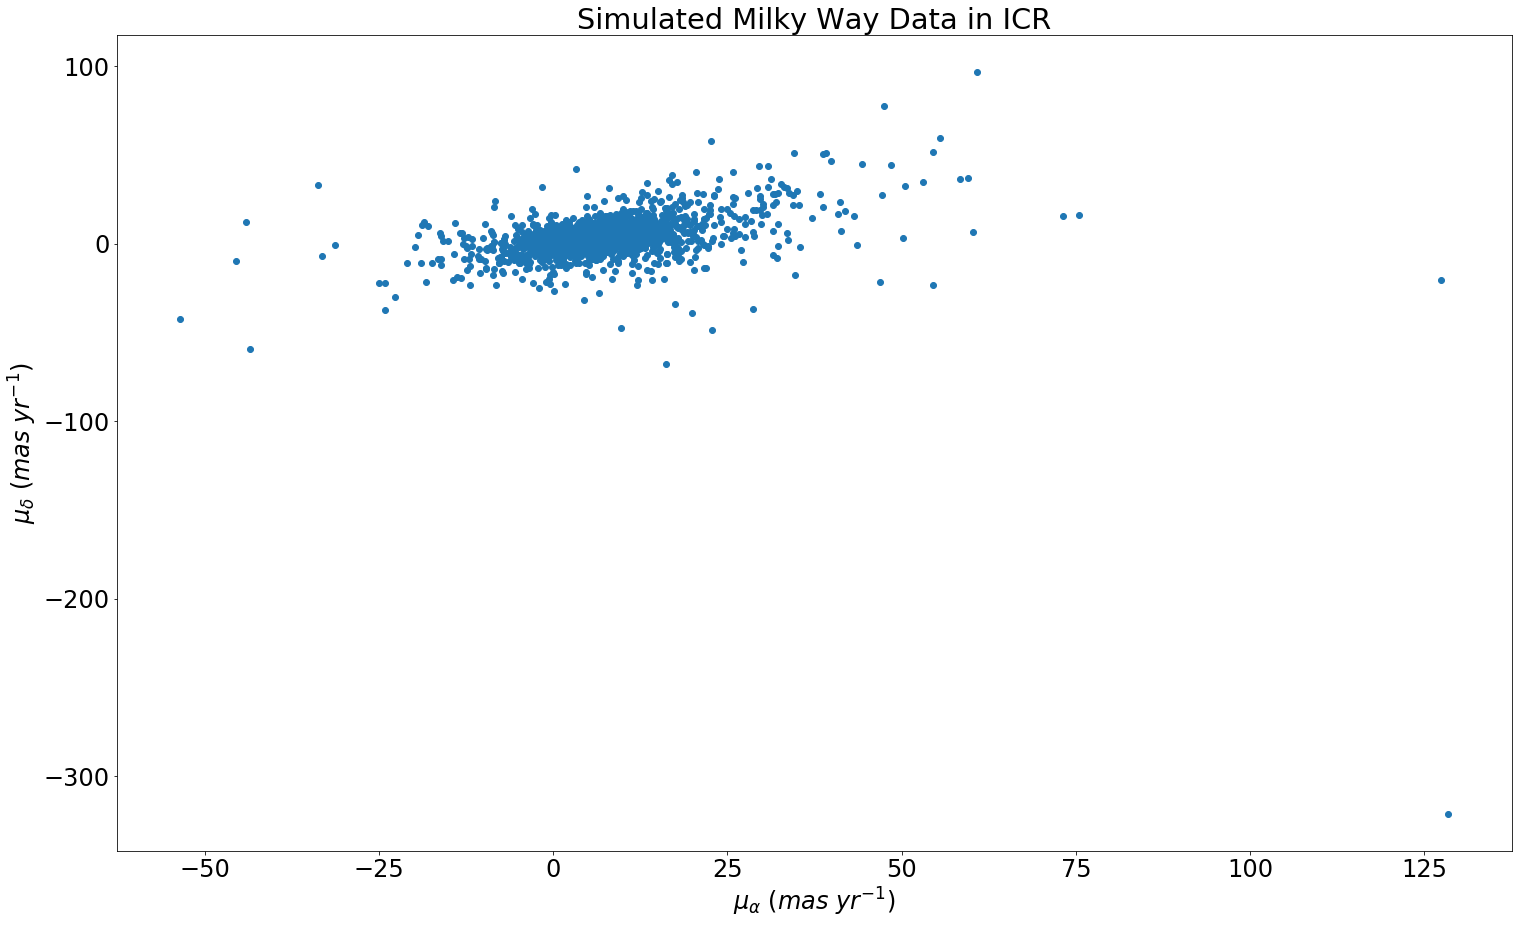

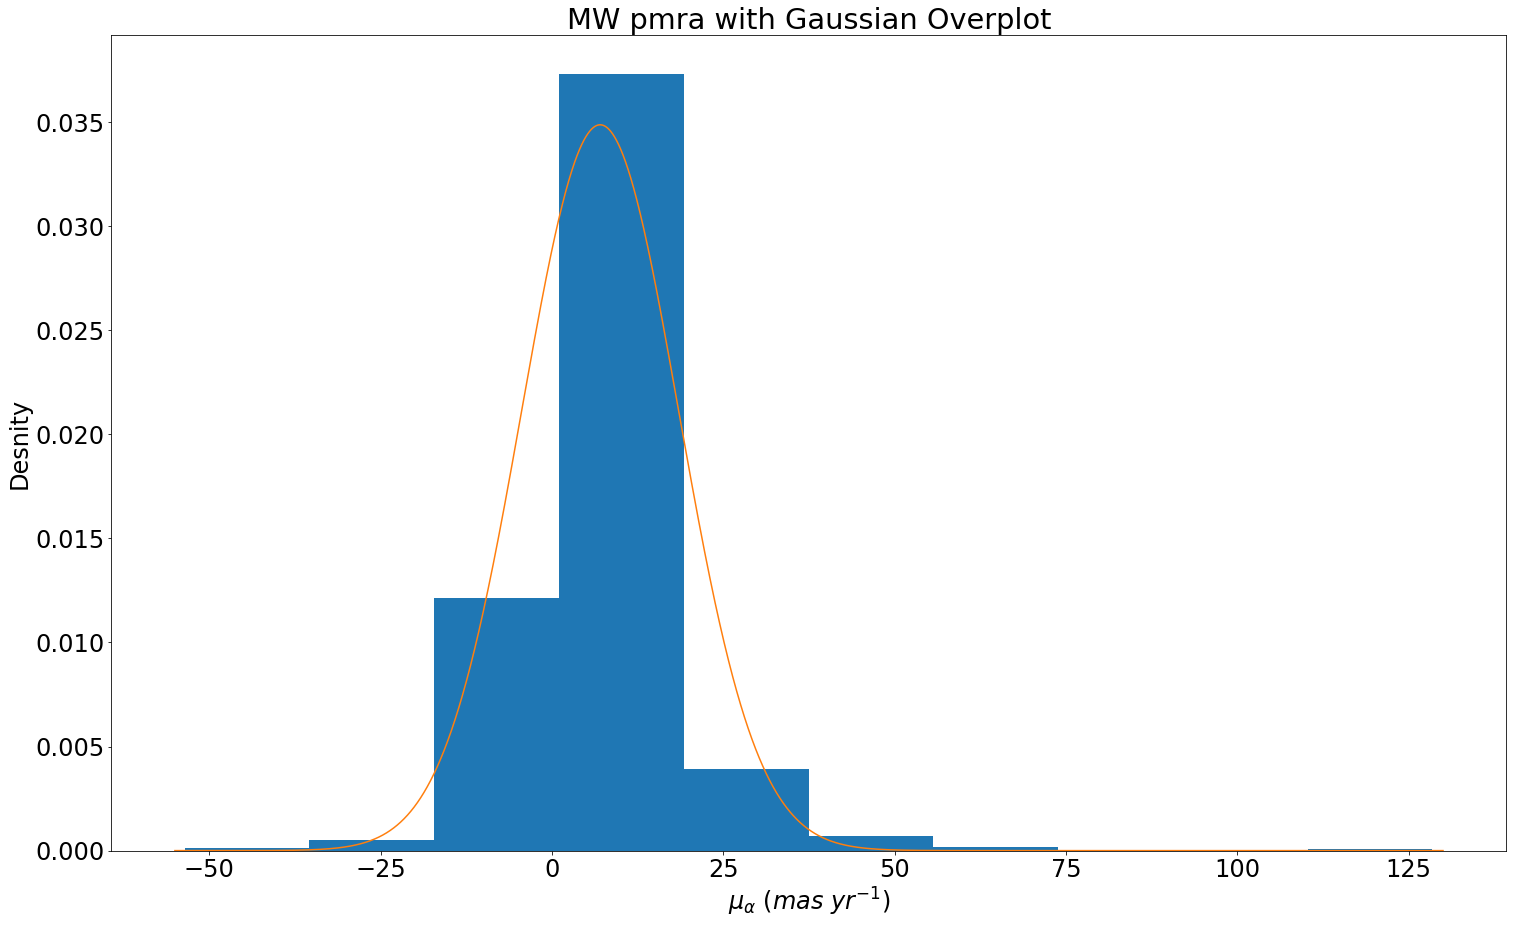

mean = 7.041079219288174
std = 11.439384878122633
skew = 2.0736814983651577
kurt = 18.33896458093757
median = 5.734999999999999
IQR = 9.73


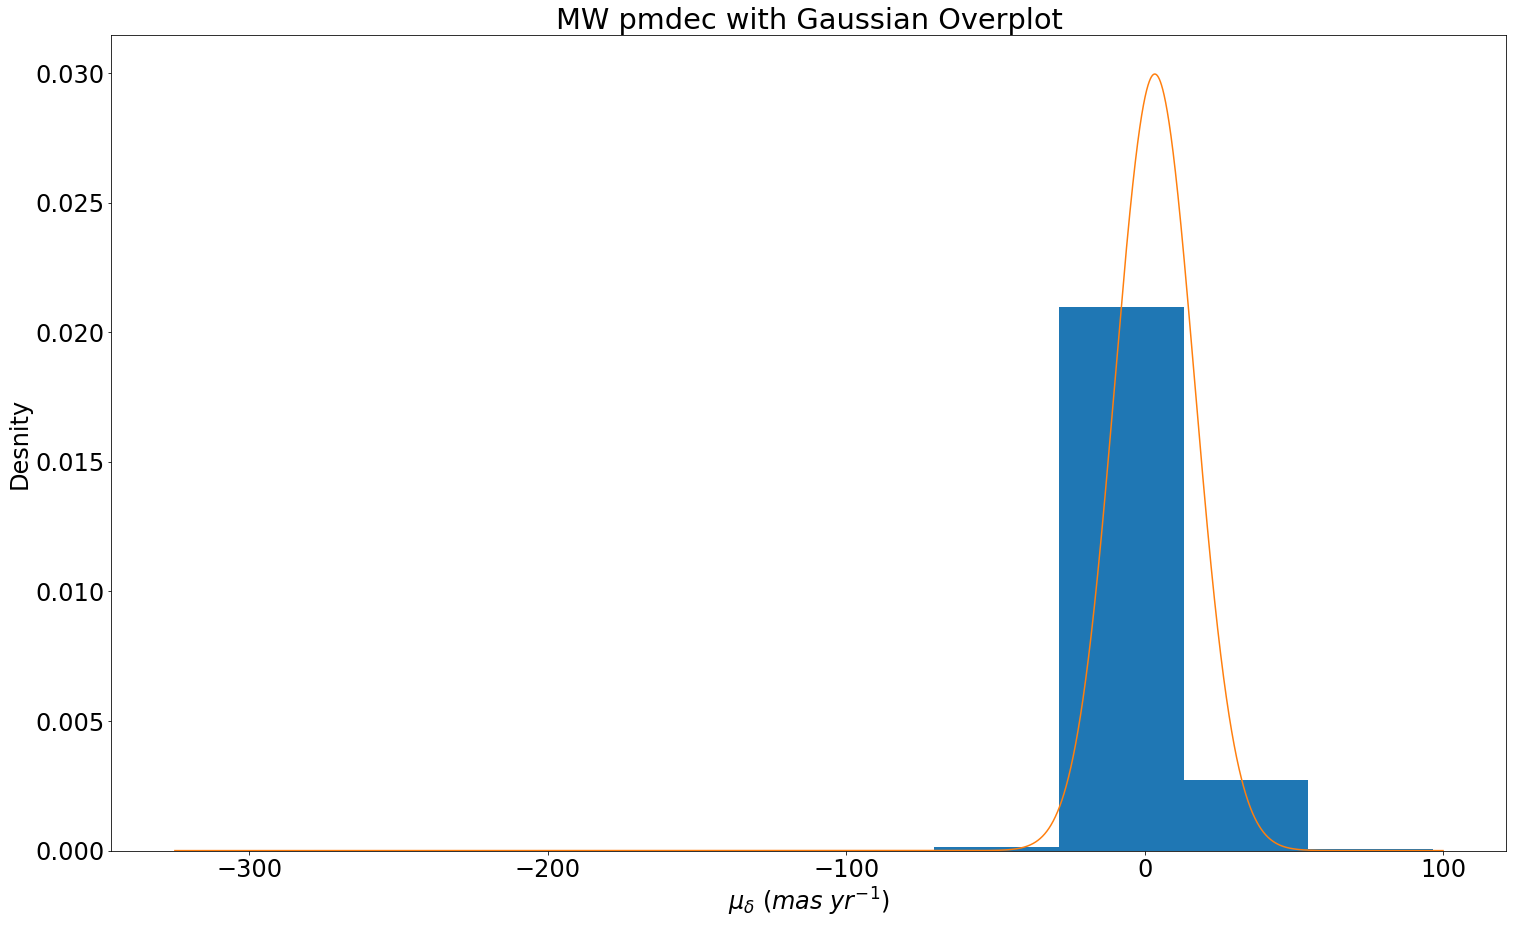

mean = 3.3980367393800224
std = 13.312777497970727
skew = -7.904045585307047
kurt = 205.04349721472977
median = 2.965
IQR = 9.215000000000002


In [18]:
###Milky Way Simulated proper motions 

#Read in Simulated Milky Way Data for ICR 
bes = astropy.io.ascii.read('/Users/joshpovick/Desktop/Research/MS_young/besancon.dat')
mpmra = bes['mux']*10.0
mpmdec = bes['muy']*10.0

#Scatter plot of MW proper motions
plt.figure(figsize=[25,15])
plt.scatter(mpmra,mpmdec)
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Simulated Milky Way Data in ICR')
plt.savefig('simmwpm.pdf',bbox_inches='tight')
plt.show()

#pmra histogram with gaussian overplot
cleanmpmra = [x for x in mpmra if str(x) != 'nan']
avgmpmra = np.mean(cleanmpmra)
sigmpmra = np.std(cleanmpmra)
zmra = np.linspace(-55,130,10000)

plt.figure(figsize=[25,15])
plt.hist(cleanmpmra, density=True)
plt.plot(zmra,gaussian(zmra,avgmpmra,sigmpmra))
plt.title('MW pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmra.pdf',bbox_inches='tight')
plt.show()

#pmra statistics
print('mean = '+ str(np.mean(cleanmpmra)))
print('std = '+ str(np.std(cleanmpmra)))
print('skew = '+ str(skew(cleanmpmra)))
print('kurt = '+ str(kurtosis(cleanmpmra)))
print('median = '+ str(np.median(cleanmpmra)))
print('IQR = '+ str(iqr(cleanmpmra)))

#pmdec histogram with gaussian overplot
cleanmpmdec = [x for x in mpmdec if str(x) != 'nan']
avgmpmdec = np.mean(cleanmpmdec)
sigmpmdec = np.std(cleanmpmdec)
zmdec = np.linspace(-325,100,10000)

fig = plt.figure(figsize=[25,15])
plt.hist(cleanmpmdec, density=True)
plt.plot(zmdec,gaussian(zmdec,avgmpmdec,sigmpmdec))
plt.title('MW pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmdec.pdf',bbox_inches='tight')
plt.show()

#pmdec statictics 
print('mean = '+ str(np.mean(cleanmpmdec)))
print('std = '+ str(np.std(cleanmpmdec)))
print('skew = '+ str(skew(cleanmpmdec)))
print('kurt = '+ str(kurtosis(cleanmpmdec)))
print('median = '+ str(np.median(cleanmpmdec)))
print('IQR = '+ str(iqr(cleanmpmdec)))

For all the sets of data the skewness and kurtosis for all sets of the data is not well bounded it will be better to use the median and median absolute deviation to describe the characteristicistic proper motion and spread respectively.

In [19]:
###Median Absolute Deviation
def mad(xdata):
    return np.median(np.absolute(xdata-np.median(xdata)))

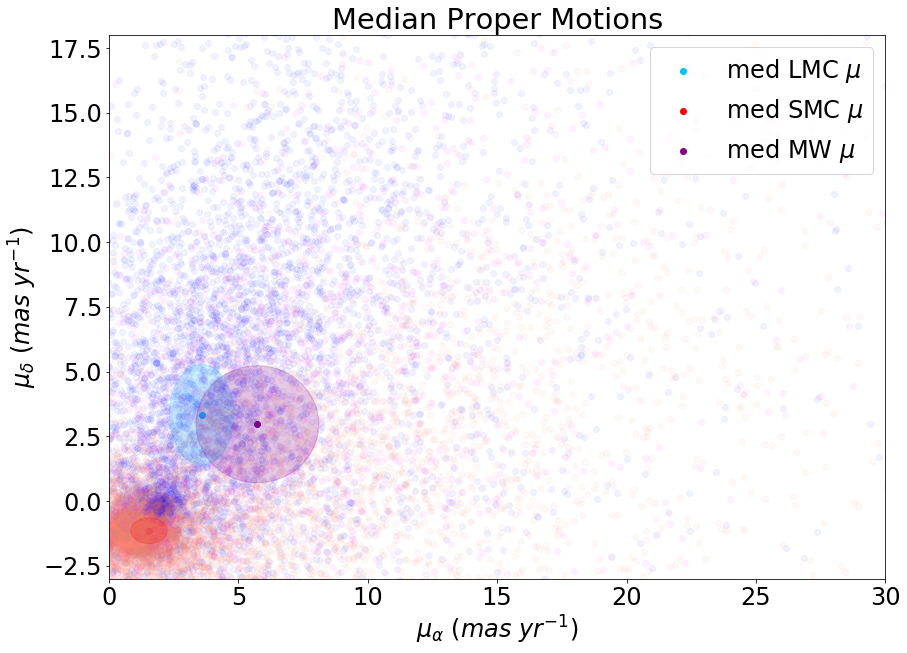

In [25]:
###Median Plots
from matplotlib.patches import Ellipse, Rectangle

pmra_dat = [np.median(cleanlpmra),np.median(cleanspmra),np.median(cleanmpmra)]
pmdec_dat = [np.median(cleanlpmdec),np.median(cleanspmdec),np.median(cleanmpmdec)]

ells = [Ellipse((pmra_dat[0], pmdec_dat[0]),mad(cleanlpmra),mad(cleanlpmdec),0,color='deepskyblue'),Ellipse((pmra_dat[1], pmdec_dat[1]),mad(cleanspmra),mad(cleanspmdec),0,color='red'),Ellipse((pmra_dat[2], pmdec_dat[2]),mad(cleanmpmra),mad(cleanmpmdec),0,color='purple')]

plt.figure(figsize=[15,10])
a = plt.subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.2)
    a.add_artist(e)

plt.scatter(pmra_dat[0],pmdec_dat[0],c='deepskyblue',label='med LMC $\mu$')
plt.scatter(pmra_dat[1],pmdec_dat[1],c='red',label='med SMC $\mu$')
plt.scatter(pmra_dat[2],pmdec_dat[2],c='purple',label='med MW $\mu$')
plt.scatter(cleanlpmra,cleanlpmdec,c='b',alpha=0.05)
plt.scatter(cleanspmra,cleanspmdec,c='salmon',alpha=0.05)
plt.scatter(cleanmpmra,cleanmpmdec,c='fuchsia',alpha=0.05)
plt.title('Median Proper Motions')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(0,30)
plt.ylim(-3,18)
plt.savefig('cutmedians.pdf',bbox_inches='tight')
plt.legend()
plt.show()

The above is quite messy so Hess diagrams will be create for the LMC and SMC to pick out the red giants and a magnitude cut will be made for all three sets of data

In [20]:
###Import for Hess Diagram
from scipy.stats import binned_statistic_2d

In [26]:
###Create color magnitude cutoff function

def cutmagid(color, magnitude, cut):
    data = []
    clean1 = []
    clean2 = []
    cutdat = []
    x = []
    y = []
    z = []
    for j0 in range(len(color)):
        data.append([color[j0],magnitude[j0],str(j0)])
    
    for j1 in range(len(data)):
        if np.isfinite(data[j1][0]) == True:
            clean1.append(data[j1])
    
    for j2 in range(len(clean1)):
        if np.isfinite(clean1[j2][1]) == True:
            clean2.append(clean1[j2])
            
    for j3 in range(len(clean2)):
        if clean2[j3][1] <= cut:
            cutdat.append(clean2[j3])
        
    for j4 in range(len(cutdat)):
        x.append(cutdat[j4][0])
        y.append(cutdat[j4][1])
        z.append(int(cutdat[j4][2]))
    
    return x, y, z

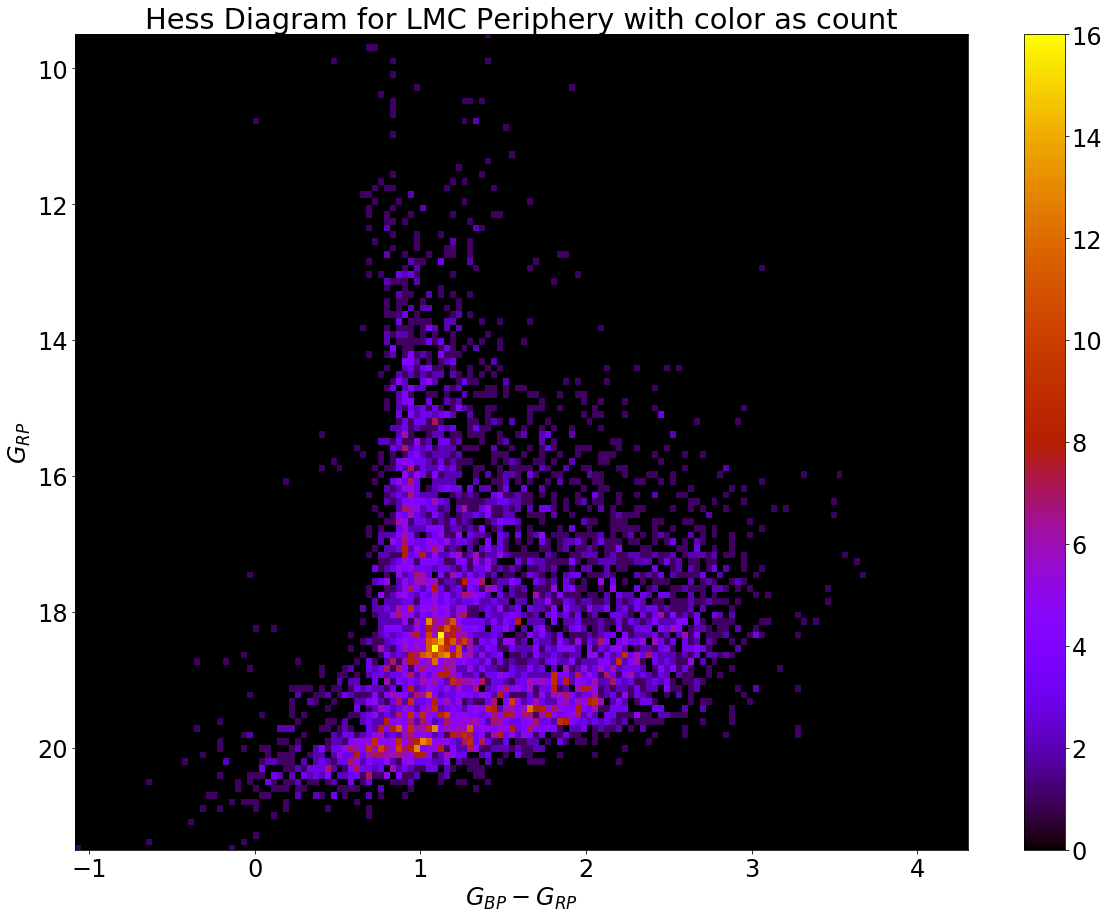

In [31]:
###Create Hess Diagram for LMC Periphery
lx, ly, lz = cutmagid(lmcper['bp_rp'],lmcper['phot_rp_mean_mag'],24)

lhess = binned_statistic_2d(lx, ly, None, 'count',bins=150)

plt.figure(figsize=[20,15])
plt.pcolormesh(lhess.x_edge,lhess.y_edge,lhess.statistic.T,cmap='gnuplot')
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for LMC Periphery with color as count')
plt.colorbar()
plt.savefig('hesslmc.pdf',bbox_inches='tight')
plt.show()

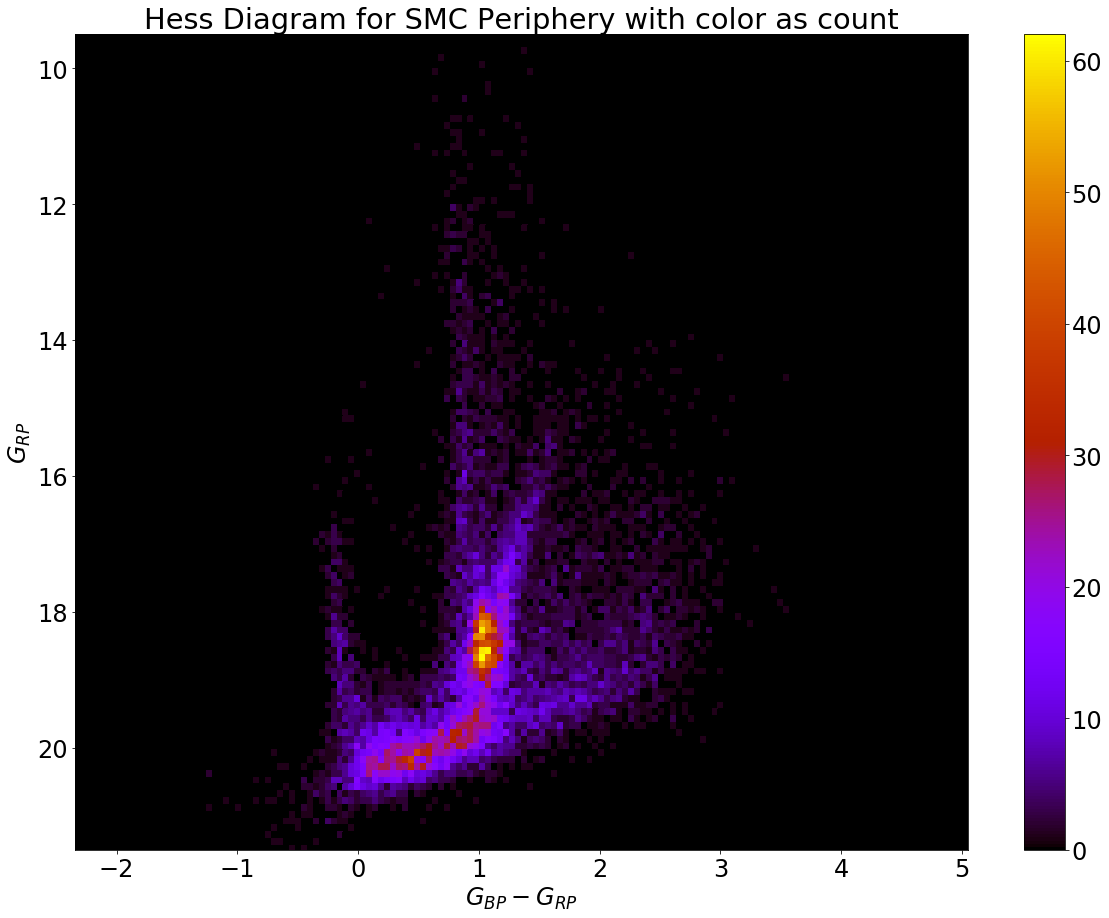

In [32]:
###Create Hess Diagram for LMC Periphery
sx, sy, sz = cutmagid(smcper['bp_rp'],smcper['phot_rp_mean_mag'],24)

shess = binned_statistic_2d(sx, sy, None, 'count',bins=150)

plt.figure(figsize=[20,15])
plt.pcolormesh(shess.x_edge,shess.y_edge,shess.statistic.T,cmap='gnuplot')
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for SMC Periphery with color as count')
plt.colorbar()
plt.savefig('hesssmc.pdf',bbox_inches='tight')
plt.show()

To pick out the red giants a rotated ellipse will be used

In [29]:
###Rotated Ellipse equation
def rotell(x,y,h,k,a,b,theta):
    return (((x-h)*np.cos(theta)+(y-k)*np.sin(theta))/a)**2 + (((x-h)*np.sin(theta)-(y-k)*np.cos(theta))/b)**2 #<=1

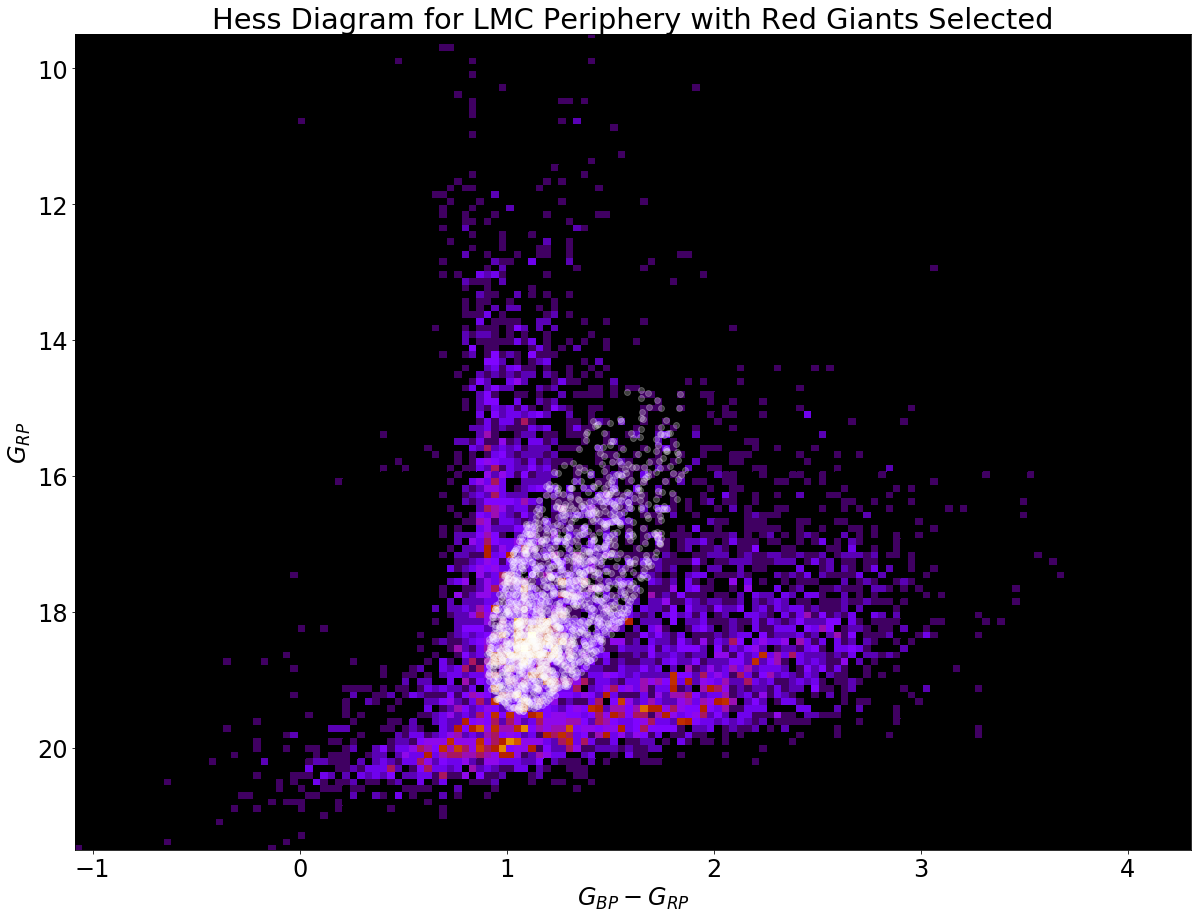

In [35]:
###Pick out the Red Giants in the LMC Periphery
lh = 1.4
lk = 17
la = 2.5
lb = 0.35
lt = np.pi/2 + 1/7
lrgbcol = []
lrgbmag = []
lrgbid = []

for k0 in range(len(lx)):
    if rotell(lx[k0],ly[k0],lh,lk,la,lb,lt) <=1:
        lrgbcol.append(lx[k0])
        lrgbmag.append(ly[k0])
        lrgbid.append(int(lz[k0]))
        

plt.figure(figsize=[20,15])
plt.pcolormesh(lhess.x_edge,lhess.y_edge,lhess.statistic.T,cmap='gnuplot')
plt.scatter(lrgbcol,lrgbmag,c='w',alpha=0.25)
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for LMC Periphery with Red Giants Selected')
plt.savefig('hesslmcrg.pdf',bbox_inches='tight')
plt.show()

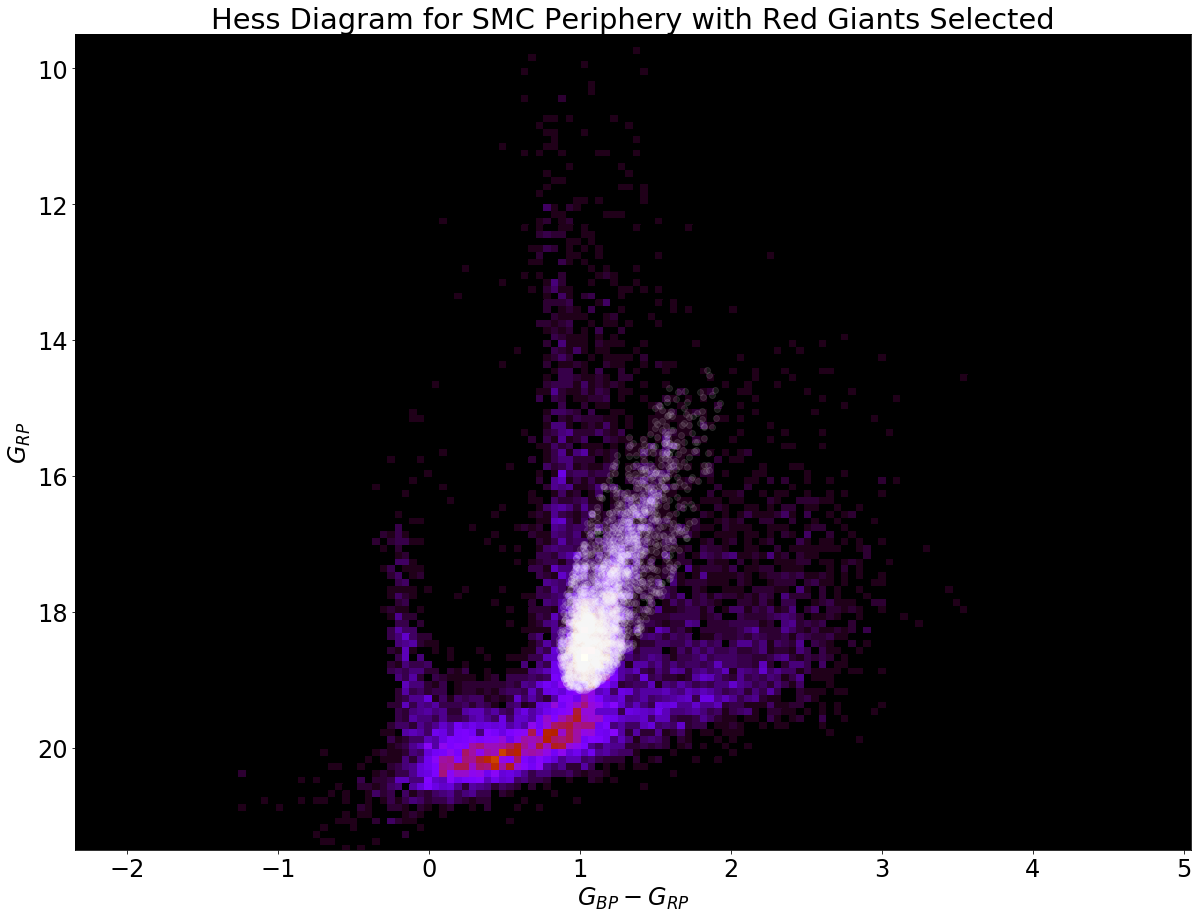

In [43]:
###Pick out the Red Giants in the SMC Periphery
sh = 1.4
sk = 16.7
sa = 2.5
sb = 0.35
st = np.pi/2 + 1/6
srgbcol = []
srgbmag = []
srgbid = []

for k0 in range(len(sx)):
    if rotell(sx[k0],sy[k0],sh,sk,sa,sb,st) <=1:
        srgbcol.append(sx[k0])
        srgbmag.append(sy[k0])
        srgbid.append(int(sz[k0]))
        

plt.figure(figsize=[20,15])
plt.pcolormesh(shess.x_edge,shess.y_edge,shess.statistic.T,cmap='gnuplot')
plt.scatter(srgbcol,srgbmag,c='w',alpha=0.1)
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for SMC Periphery with Red Giants Selected')
plt.savefig('hesssmcrg.pdf',bbox_inches='tight')
plt.show()

In [50]:
###Function to find red giants in gaia periphery data

def rgfinder(periph,indices):
    '''indices is an output of the for loop that tests if a star is in the ellipse that
    contains the red giants _rgbid'''
    rg_pmra = []
    rg_pmdec = []
    rg_dat = []
    clean_rg_dat = []
    clean_rg_dat2 = []
    a = []
    b = []
    
    for j0 in indices:
        rg_pmra.append(periph['pmra'][j0])
        rg_pmdec.append(periph['pmdec'][j0])

    for j1 in range(len(rg_pmra)):
        rg_dat.append([rg_pmra[j1],rg_pmdec[j1]])
    
    for j2 in range(len(rg_dat)):
        if np.isfinite(rg_dat[j2][0]) == True:
            clean_rg_dat.append(rg_dat[j2])

    for j3 in range(len(clean_rg_dat)):
        if np.isfinite(clean_rg_dat[j3][1]) == True:
            clean_rg_dat2.append(clean_rg_dat[j3])
        
    for j4 in range(len(clean_rg_dat2)):
        a.append(clean_rg_dat2[j4][0])
        b.append(clean_rg_dat2[j4][1])
    
    return a, b

Examining the red giant only data

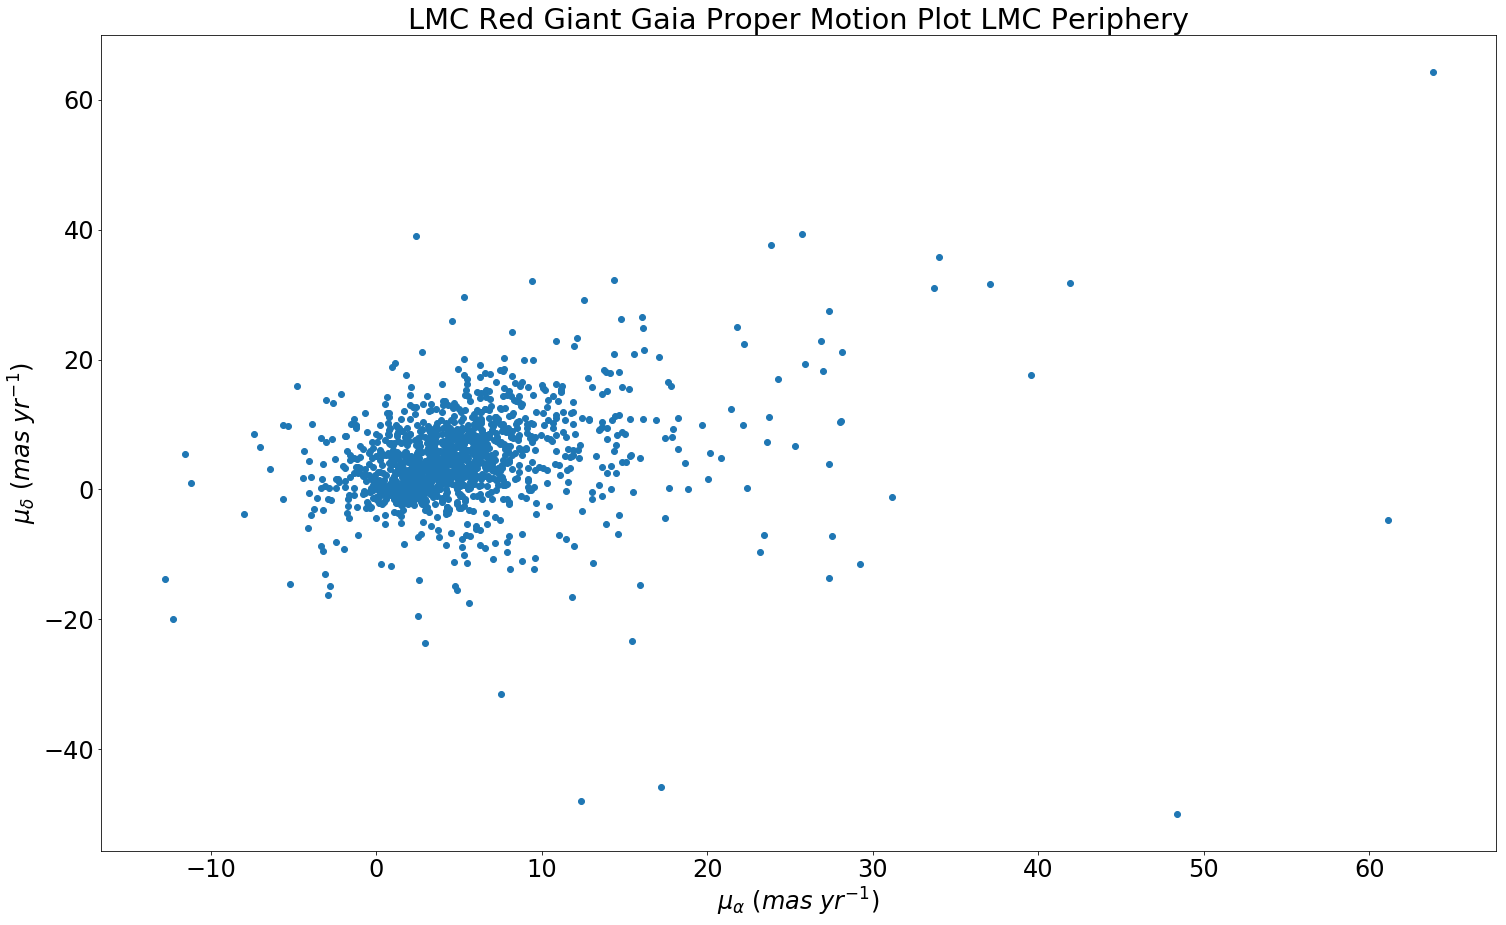

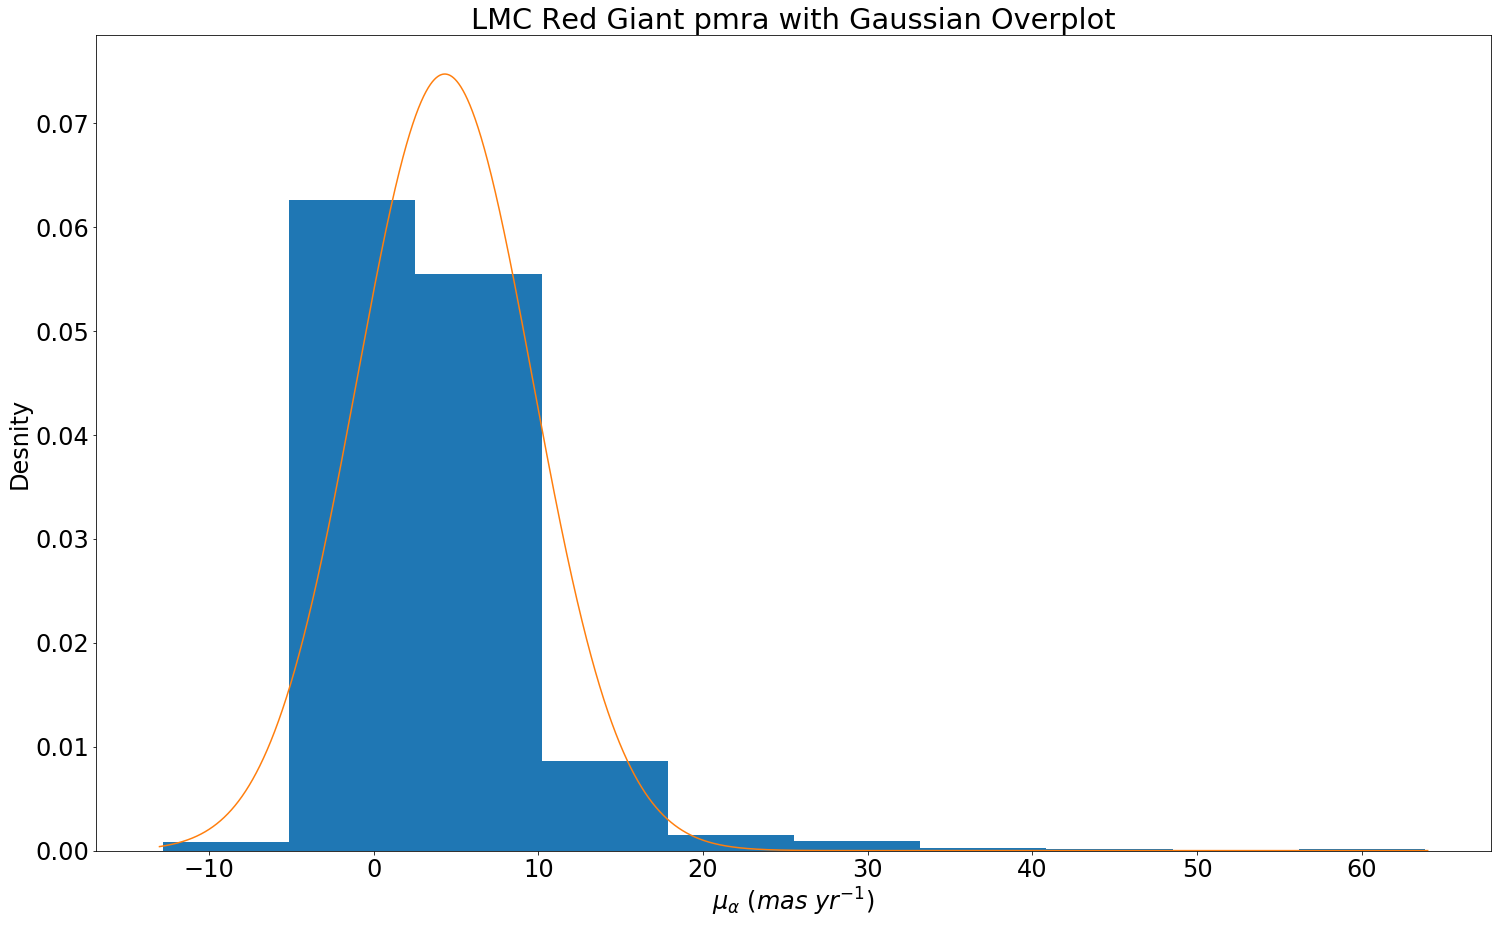

mean = 4.324555933888798
std = 5.336617572716312
skew = 3.450882152255542
kurt = 23.661604231489793
median = 2.638427294858026
IQR = 4.059055080280627
MAD = 1.5344076939303597


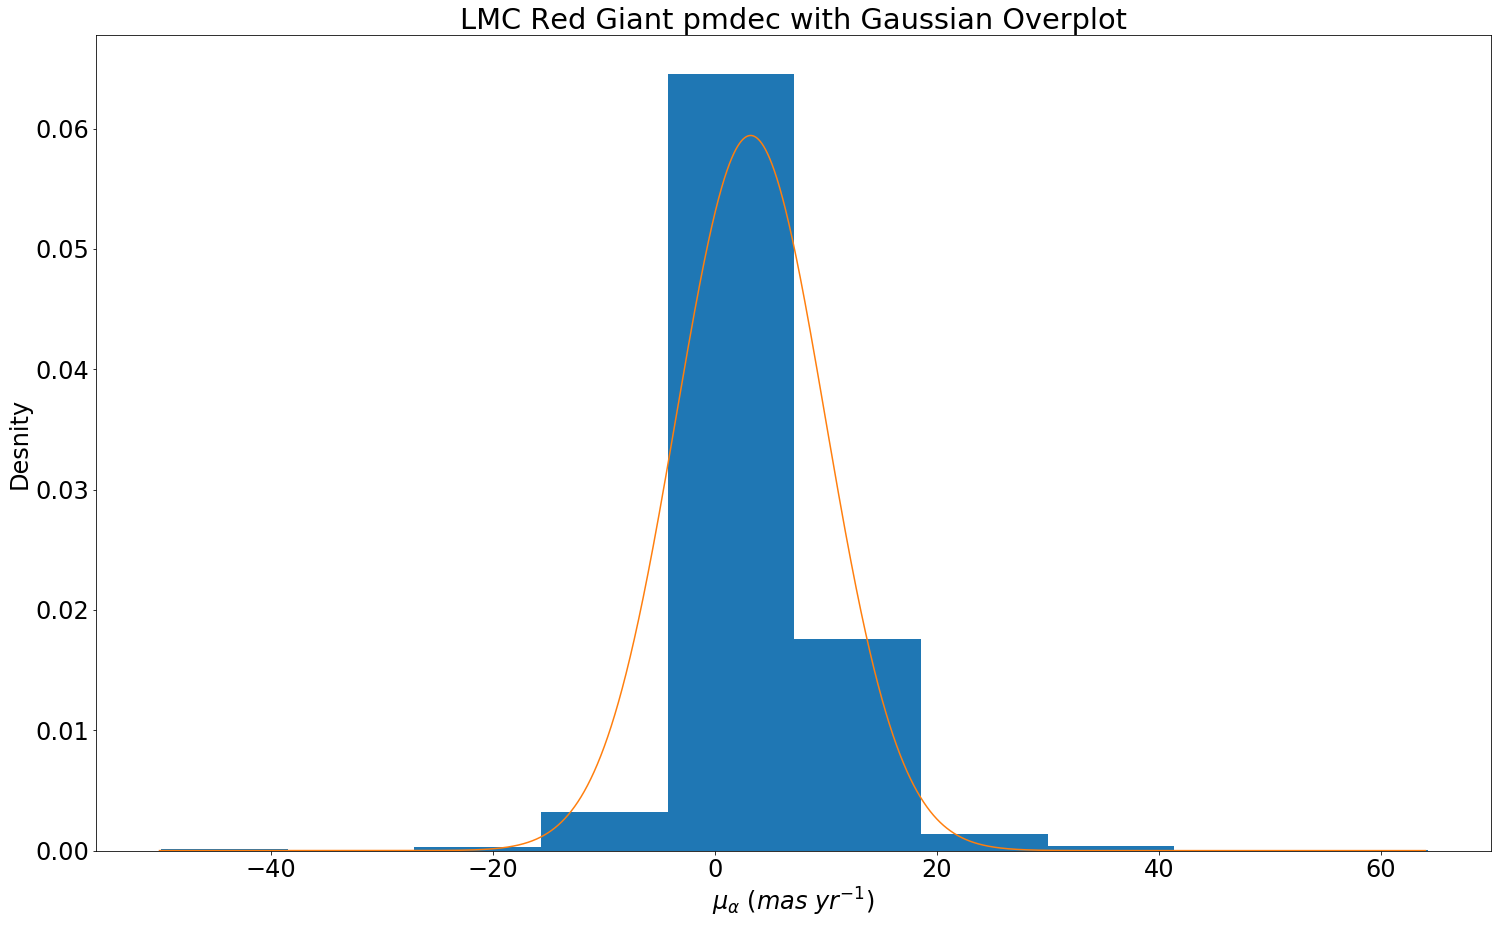

mean = 3.2377062855560688
std = 6.7132939510842125
skew = 0.4636730984420478
kurt = 11.85704801614203
median = 1.6333309966241294
IQR = 6.668277445873067
MAD = 2.420041383582304


In [51]:
###LMC red giant proper motion plot with accompanying histograms

lrgpmra, lrgpmdec = rgfinder(lmcper,lrgbid)

#Scatter plot of LMC proper motions
plt.figure(figsize=[25,15])
plt.scatter(lrgpmra,lrgpmdec)
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('LMC Red Giant Gaia Proper Motion Plot LMC Periphery')
plt.savefig('lrgpm.pdf',bbox_inches='tight')
plt.show()

#pmra histogram with gaussian overplot
avg_lpmra = np.mean(lrgpmra)
sig_lpmra = np.std(lrgpmra)
z_lra = np.linspace(round(min(lrgpmra)),round(max(lrgpmra)),10000)

plt.figure(figsize=[25,15])
plt.hist(lrgpmra, density=True)
plt.plot(z_lra,gaussian(z_lra,avg_lpmra,sig_lpmra))
plt.title('LMC Red Giant pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmra.pdf',bbox_inches='tight')
plt.show()

#pmra statistics
print('mean = '+ str(np.mean(lrgpmra)))
print('std = '+ str(np.std(lrgpmra)))
print('skew = '+ str(skew(lrgpmra)))
print('kurt = '+ str(kurtosis(lrgpmra)))
print('median = '+ str(np.median(lrgpmra)))
print('IQR = '+ str(iqr(lrgpmra)))
print('MAD = '+str(mad(lrgpmra)))

#pmdec histogram with gaussian overplot
avg_lpmdec = np.mean(lrgpmdec)
sig_lpmdec = np.std(lrgpmdec)
z_ldec = np.linspace(round(min(lrgpmdec)),round(max(lrgpmdec)),10000)

plt.figure(figsize=[25,15])
plt.hist(lrgpmdec, density=True)
plt.plot(z_ldec,gaussian(z_ldec,avg_lpmdec,sig_lpmdec))
plt.title('LMC Red Giant pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmdec.pdf',bbox_inches='tight')
plt.show()

#pmdec statistics
print('mean = '+ str(np.mean(lrgpmdec)))
print('std = '+ str(np.std(lrgpmdec)))
print('skew = '+ str(skew(lrgpmdec)))
print('kurt = '+ str(kurtosis(lrgpmdec)))
print('median = '+ str(np.median(lrgpmdec)))
print('IQR = '+ str(iqr(lrgpmdec)))
print('MAD = '+str(mad(lrgpmdec)))

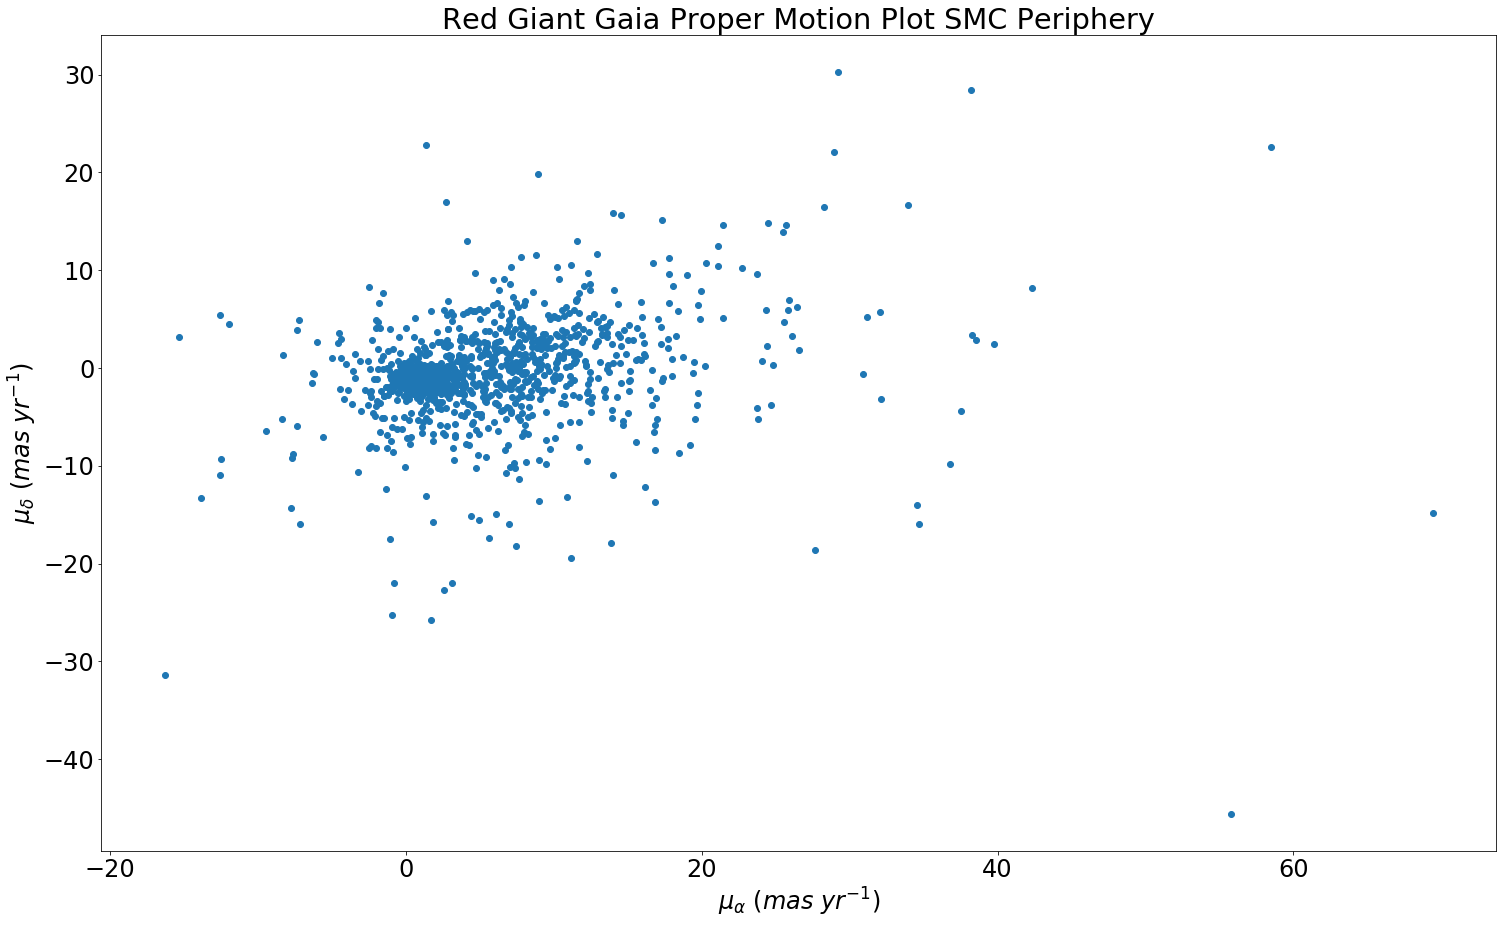

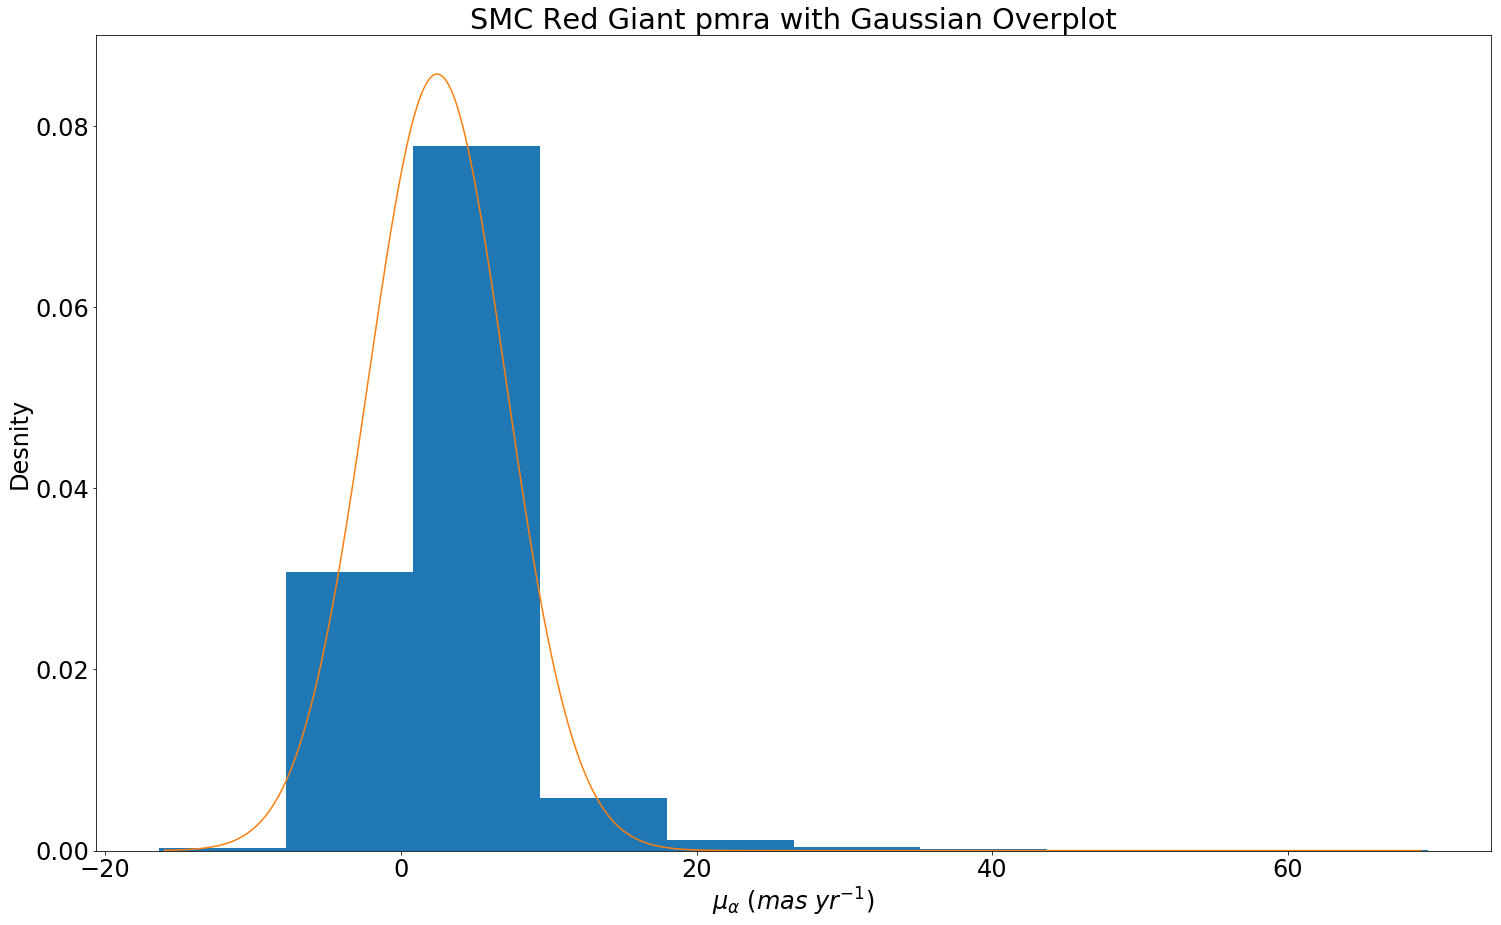

mean = 4.324555933888798
std = 5.336617572716312
skew = 3.450882152255542
kurt = 23.661604231489793
median = 2.638427294858026
IQR = 4.059055080280627
MAD = 1.5344076939303597


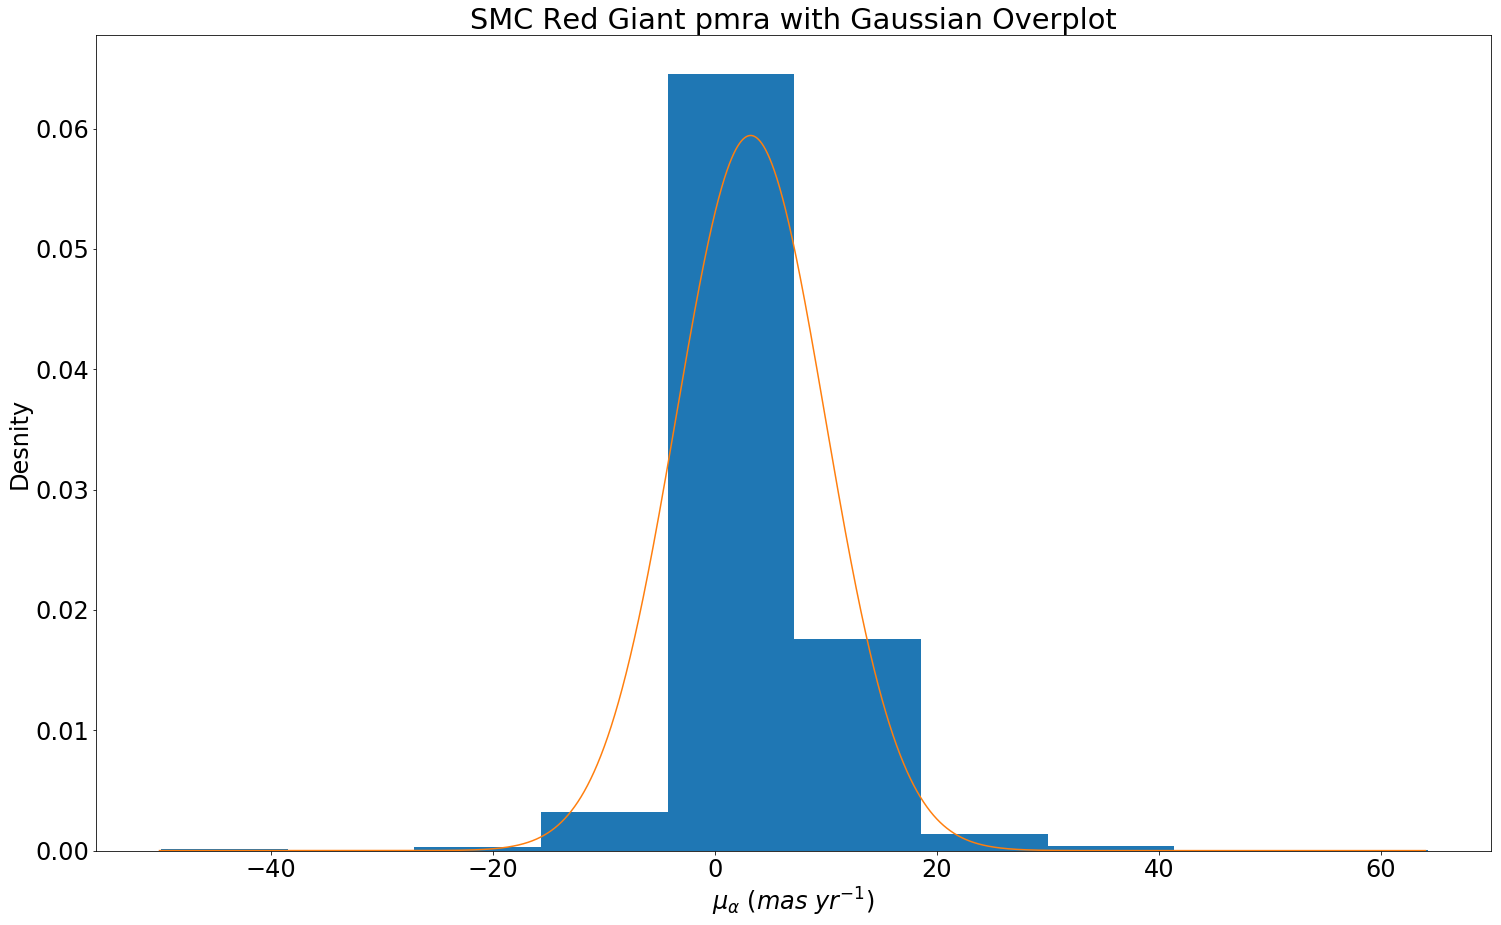

mean = 3.2377062855560688
std = 6.7132939510842125
skew = 0.4636730984420478
kurt = 11.85704801614203
median = 1.6333309966241294
IQR = 6.668277445873067
MAD = 2.420041383582304


In [52]:
###SMC red giant proper motion plot with accompanying histograms

srgpmra, srgpmdec = rgfinder(smcper,srgbid)

#Scatter plot of SMC proper motions
plt.figure(figsize=[25,15])
plt.scatter(srgpmra,srgpmdec)
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Red Giant Gaia Proper Motion Plot SMC Periphery')
plt.savefig('srgpm.pdf',bbox_inches='tight')
plt.show()

#pmra histogram with gaussian overplot
avg_spmra = np.mean(srgpmra)
sig_spmra = np.std(srgpmra)
z_sra = np.linspace(round(min(srgpmra)),round(max(srgpmra)),10000)

plt.figure(figsize=[25,15])
plt.hist(srgpmra, density=True)
plt.plot(z_sra,gaussian(z_sra,avg_spmra,sig_spmra))
plt.title('SMC Red Giant pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmra.pdf',bbox_inches='tight')
plt.show()

#pmra statistics
print('mean = '+ str(np.mean(lrgpmra)))
print('std = '+ str(np.std(lrgpmra)))
print('skew = '+ str(skew(lrgpmra)))
print('kurt = '+ str(kurtosis(lrgpmra)))
print('median = '+ str(np.median(lrgpmra)))
print('IQR = '+ str(iqr(lrgpmra)))
print('MAD = '+str(mad(lrgpmra)))

#pmdec histogram with gaussian overplot
avg_lpmdec = np.mean(lrgpmdec)
sig_lpmdec = np.std(lrgpmdec)
z_ldec = np.linspace(round(min(lrgpmdec)),round(max(lrgpmdec)),10000)

plt.figure(figsize=[25,15])
plt.hist(lrgpmdec, density=True)
plt.plot(z_ldec,gaussian(z_ldec,avg_lpmdec,sig_lpmdec))
plt.title('SMC Red Giant pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmdec.pdf',bbox_inches='tight')
plt.show()

#pmdec statistics
print('mean = '+ str(np.mean(lrgpmdec)))
print('std = '+ str(np.std(lrgpmdec)))
print('skew = '+ str(skew(lrgpmdec)))
print('kurt = '+ str(kurtosis(lrgpmdec)))
print('median = '+ str(np.median(lrgpmdec)))
print('IQR = '+ str(iqr(lrgpmdec)))
print('MAD = '+str(mad(lrgpmdec)))

The data for the red giants still has high kurtosis so it would be best to stay with the median and median absolute deviation

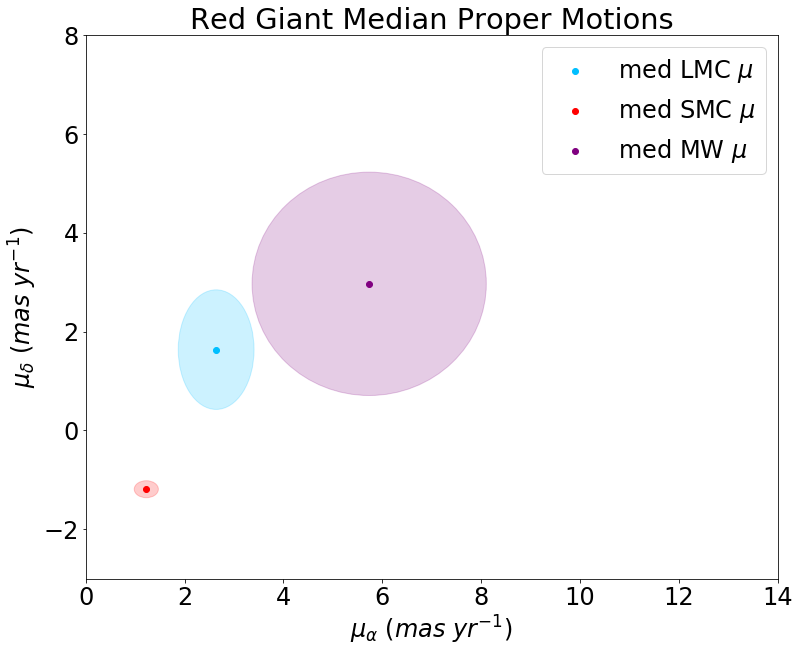

In [69]:
###Median plot for the three data sets with the spread as ellipses
pmra_dat1 = [np.median(lrgpmra),np.median(srgpmra),np.median(mpmra)]
pmdec_dat1 = [np.median(lrgpmdec),np.median(srgpmdec),np.median(mpmdec)]

ells = [Ellipse((pmra_dat1[0], pmdec_dat1[0]),mad(lrgpmra),mad(lrgpmdec),0,color='deepskyblue'),Ellipse((pmra_dat1[1], pmdec_dat1[1]),mad(srgpmra),mad(srgpmdec),0,color='red'),Ellipse((pmra_dat1[2], pmdec_dat1[2]),mad(mpmra),mad(mpmdec),0,color='purple')]

plt.figure(figsize=[15,10])
a = plt.subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.2)
    a.add_artist(e)

plt.scatter(pmra_dat1[0],pmdec_dat1[0],c='deepskyblue',label='med LMC $\mu$')
plt.scatter(pmra_dat1[1],pmdec_dat1[1],c='red',label='med SMC $\mu$')
plt.scatter(pmra_dat1[2],pmdec_dat1[2],c='purple',label='med MW $\mu$')
plt.title('Red Giant Median Proper Motions')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(0,14)
plt.ylim(-3,8)
plt.savefig('cutrgmedians.pdf',bbox_inches='tight')
plt.legend()
plt.show()

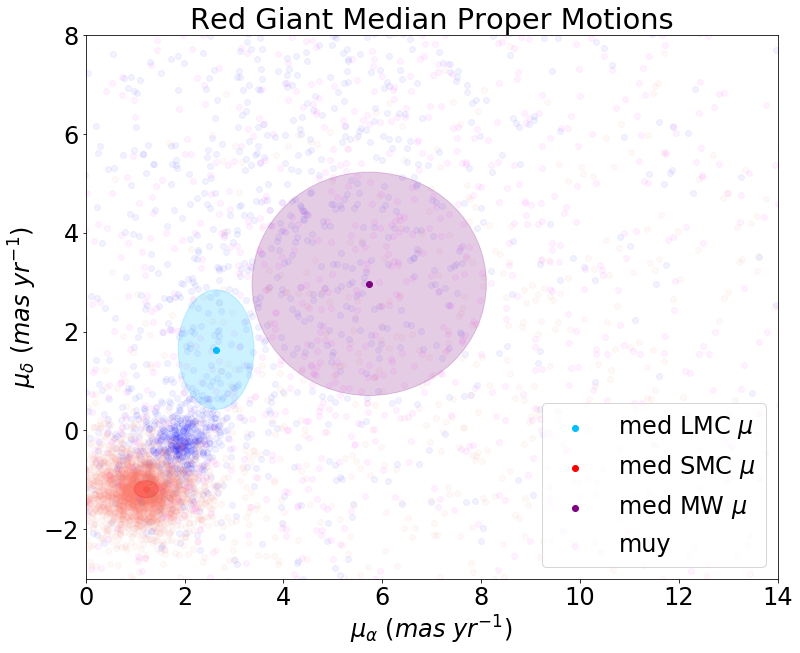

In [68]:
###Median plot for the three data sets with the spread as ellipses
pmra_dat1 = [np.median(lrgpmra),np.median(srgpmra),np.median(mpmra)]
pmdec_dat1 = [np.median(lrgpmdec),np.median(srgpmdec),np.median(mpmdec)]

ells = [Ellipse((pmra_dat1[0], pmdec_dat1[0]),mad(lrgpmra),mad(lrgpmdec),0,color='deepskyblue'),Ellipse((pmra_dat1[1], pmdec_dat1[1]),mad(srgpmra),mad(srgpmdec),0,color='red'),Ellipse((pmra_dat1[2], pmdec_dat1[2]),mad(mpmra),mad(mpmdec),0,color='purple')]

plt.figure(figsize=[15,10])
a = plt.subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.2)
    a.add_artist(e)

plt.scatter(pmra_dat1[0],pmdec_dat1[0],c='deepskyblue',label='med LMC $\mu$')
plt.scatter(pmra_dat1[1],pmdec_dat1[1],c='red',label='med SMC $\mu$')
plt.scatter(pmra_dat1[2],pmdec_dat1[2],c='purple',label='med MW $\mu$')
plt.scatter(lrgpmra,lrgpmdec,c='b',alpha=0.05)
plt.scatter(srgpmra,srgpmdec,c='salmon',alpha=0.05)
plt.scatter(mpmra,mpmdec,c='fuchsia',alpha=0.05)
plt.title('Red Giant Median Proper Motions')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(0,14)
plt.ylim(-3,8)
plt.savefig('cutrgmedians.pdf',bbox_inches='tight')
plt.legend()
plt.show()